In [1]:
# %pip install  tqdm iprogress ipywidgets numpy pandas -U
# %pip install torch matplotlib dtaidistance -U
# %pip install scikit-learn
# %pip install numpy --pre 
# %pip install torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu118


In [2]:
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from json import JSONEncoder
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import signal
from dtaidistance import dtw, similarity

In [3]:
# set random seed for reproducibility
# np.random.seed(1001)
# torch.manual_seed(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device  

device(type='cpu')

In [5]:
# For saving in RTNeural format
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)

In [6]:
# The LSTM model based on RTNeural and GuitarML paper
class Model(torch.nn.Module):
    def __init__(self, hidden_size=8):
        super().__init__()
        self.lstm = torch.nn.LSTM(1, hidden_size)
        self.dense = torch.nn.Linear(hidden_size, 1)

    def forward(self, torch_in):
        x, _ = self.lstm(torch_in)
        return self.dense(x)

In [7]:
def gold_transform(x):
    return x*2

(10000,)


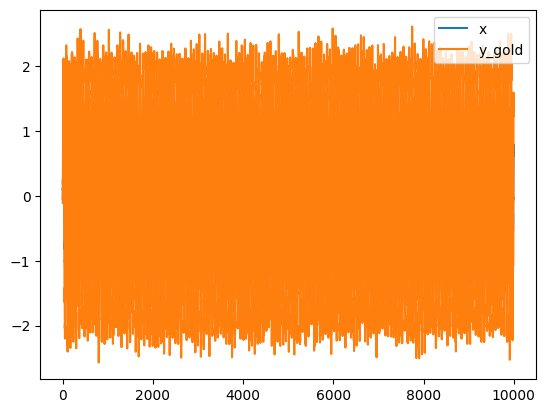

In [8]:
# Let's make an input and gold output
XLEN = 1000
x = np.sin(np.arange(0, XLEN, 0.1)) + np.random.normal(0, 0.1, XLEN*10)

# gold output is  just input amplified by 2
y_gold = gold_transform(x)

print(y_gold.shape)
plt.plot(x)
plt.plot(y_gold)
plt.legend(['x', 'y_gold'])
plt.show()


(10000, 1)


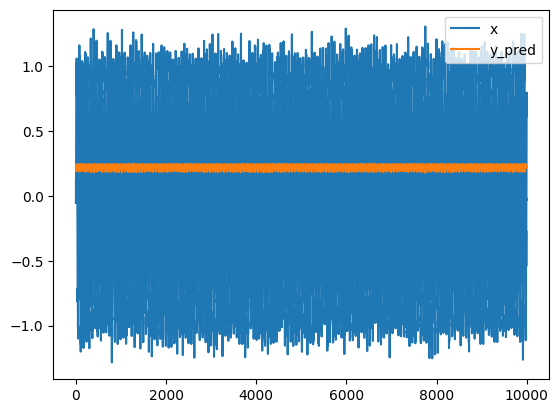

In [9]:
# without any training
x_tensor = torch.from_numpy(x.astype(np.float32)).reshape(-1, 1).to(device)
model = Model().to(device)
y_pred = model.forward(x_tensor).detach().cpu().numpy()
print(np.shape(y_pred))
plt.plot(x)
plt.plot(y_pred)
plt.legend(['x', 'y_pred'])
plt.show()

In [10]:
# Let's train!
NUM_EPOCHS = 1000
hidden_size=64
eps = 0.00001
model = Model(hidden_size=hidden_size).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
y_gold_tensor = torch.tensor(y_gold, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

losses = []  # to store loss values
predictions = []  # to store predictions

model.train()
epochs = NUM_EPOCHS  # set the number of epochs
cur_loss = 1000
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_gold_tensor)
    loss.backward()
    optimizer.step()
    predictions.append(y_pred.detach().cpu().numpy())  # Saving predictions
    losses.append(loss.item())

  
    # fix this to early stop when loss doesn't change by more than eps
    if abs(cur_loss - loss.item()) < eps:
        # predictions.append(y_pred.detach().numpy())  # Saving predictions
        # losses.append(loss.item())
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        break

    cur_loss = loss.item()
    #  Print loss every 100 epochs
    if epoch % 100 == 0:
        # predictions.append(y_pred.detach().numpy())  # Saving predictions
        # losses.append(loss.item())
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 2.0805857181549072
Epoch 100, Loss: 1.3343254327774048
Epoch 200, Loss: 0.07886314392089844
Epoch 270, Loss: 0.00048439507372677326


In [15]:
print(x_tensor.shape)

torch.Size([1, 10000, 1])


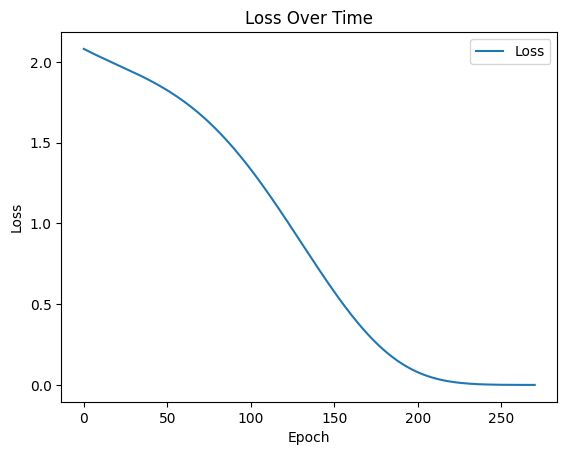

In [11]:
# Plotting the loss
plt.plot(np.arange(len(predictions)), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

(271, 1, 10000, 1)
(271, 10000)


/home/agman/Documents/MCS/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


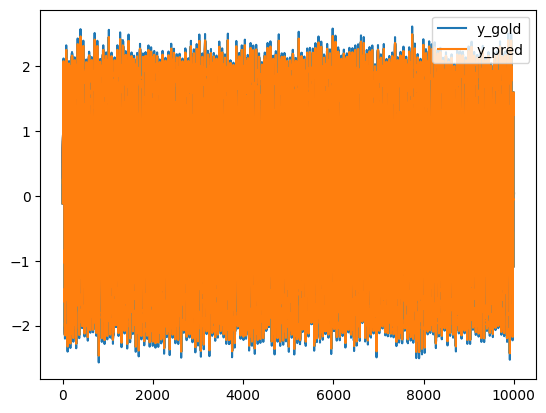

In [12]:
# plot the predictions versus gold
print(np.shape(predictions))
y_pred_1d = [p.squeeze() for p in predictions]
print(np.shape(y_pred_1d))

plt.plot(y_gold)
for y in y_pred_1d:
    plt.plot(y)
plt.legend(['y_gold', 'y_pred'])
plt.show()

(28, 10000)


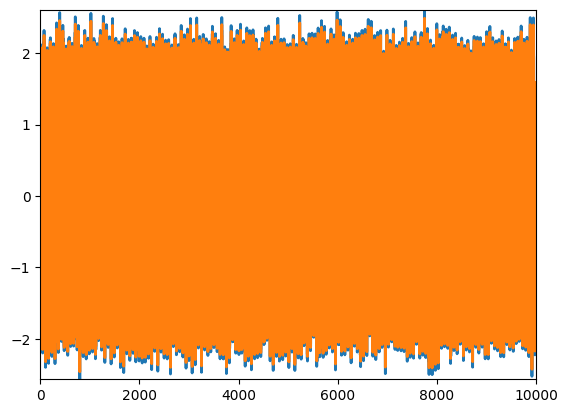

In [13]:
# %matplotlib 
y_pred_1d = [p.squeeze() for p in predictions[::10]] 
print(np.shape(y_pred_1d)) 
y_range = range(len(y_gold))
fig, ax = plt.subplots()
ax.set_xlim(0, len(y_gold))
ax.set_ylim(min(y_gold), max(y_gold ))

# Plot y_gold
y_gold_line, = ax.plot([], [], label='y_gold', lw=2)
y_gold_line.set_data(y_range, y_gold)

# Initialize an empty line for the predictions
y_pred_line, = ax.plot([], [], label='y_pred', lw=2)

def init():
    y_pred_line.set_data([], [])
    return y_gold_line, y_pred_line

def update(frame):
    # Update the data for the y_pred_line
    y_pred_line.set_data(y_range, y_pred_1d[frame])
    return y_gold_line, y_pred_line

ani = FuncAnimation(fig, update, frames=range(len(y_pred_1d)), 
                    init_func=init, blit=True, repeat=False, interval=100)
HTML(ani.to_html5_video())

# ax.legend()
# plt.show()

In [14]:
# let's make a input of a random waveform and run N times
NUM_TESTS = 1000
y_pred_test_list = []
for i in tqdm(range(NUM_TESTS)):
    # x_test = np.random.rand(len(x))
    x_test = np.sin(x*np.random.normal()) + np.random.normal(scale=0.1, size=len(x))
    y_gold_test = gold_transform(x_test)

    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    y_pred_test = model(x_test_tensor).detach().cpu().numpy().squeeze()
    y_pred_test_list.append(y_pred_test)

fig, ax = plt.subplots()
# plt.plot(x_test)
plt.plot(y_gold_test)
plt.plot(y_pred_test)
plt.legend(['x_test', 'y_pred_test'])
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# a whole bunch of stats
differences = [(y_gold_test) - y_pred_test for y_pred_test in y_pred_test_list]
abs_differences = [np.abs(d) for d in differences]
max_differences = [np.max(d) for d in differences]
min_differences = [np.max(d) for d in differences]
mean_differences = [np.mean(d) for d in differences]
variances = [np.var(d) for d in differences]
s_divs = [np.std(d) for d in differences]
correlations = [np.corrcoef(y_gold_test, y_pred_test)[0, 1] for y_pred_test in y_pred_test_list]
mse_values = [np.mean((y_gold_test - y_pred_test)**2) for y_pred_test in y_pred_test_list]
rmse_values = [np.sqrt(mse) for mse in mse_values]

In [ ]:
# print stats
print(f'max difference: {np.max(max_differences)}')
print(f'min difference: {np.min(min_differences)}')
print(f'mean difference: {np.mean(mean_differences)}')
print(f'variance: {np.mean(variances)}')
print(f'standard deviation: {np.mean(s_divs)}')
print(f'correlation: {np.mean(correlations)}')
print(f'mse: {np.mean(mse_values)}')
print(f'rmse: {np.mean(rmse_values)}')

max difference: 4.602074381510606
min difference: 0.06565755746289925
mean difference: -0.00411974175415711
variance: 2.240433695872917
standard deviation: 1.2601299821975978
correlation: 0.02599437778847812
mse: 2.240534252850147
rmse: 1.2601873341834793


(101, 101)


[]

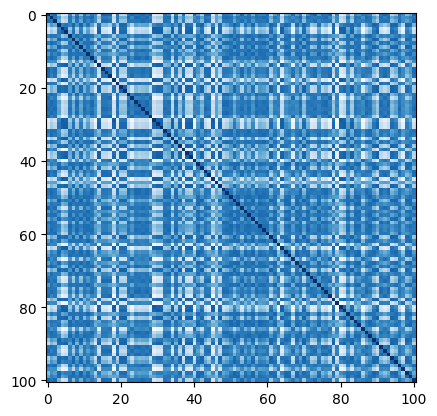

In [ ]:
# Mucking around with simlarity using DTW
s = np.vstack([np.array(y_gold), np.array([y for y in y_pred_test_list[:100]])])
sim = similarity.distance_to_similarity(dtw.distance_matrix_fast(s))
print(sim.shape)
# sim = similarity.squash(s)
plt.imshow(sim, cmap='Blues', interpolation='nearest')
plt.plot()


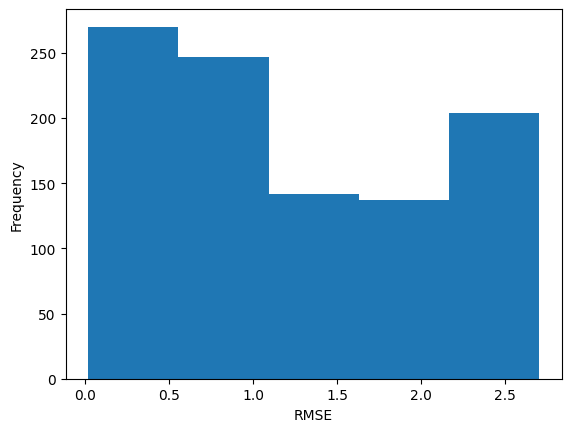

In [ ]:
plt.hist(rmse_values, bins=5)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

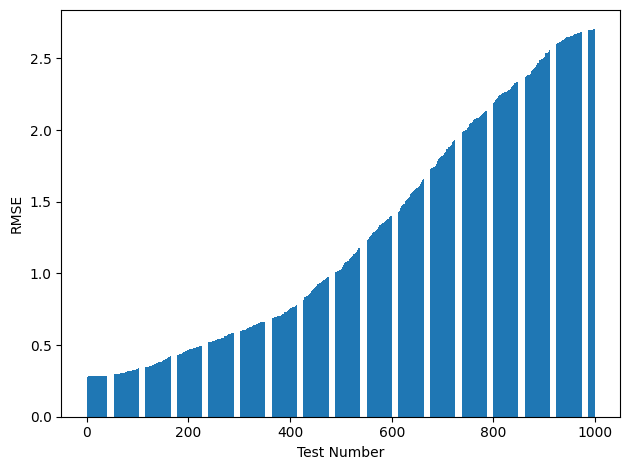

In [ ]:
plt.bar(range(NUM_TESTS), sorted(rmse_values))
# plt.xticks(range(NUM_TESTS), labels=[f'{i+1}' for i in range(NUM_TESTS)])  # Labeling x-axis with test numbers
plt.xlabel('Test Number')  # x-axis label
plt.ylabel('RMSE')  # y-axis label
plt.tight_layout()
plt.show()

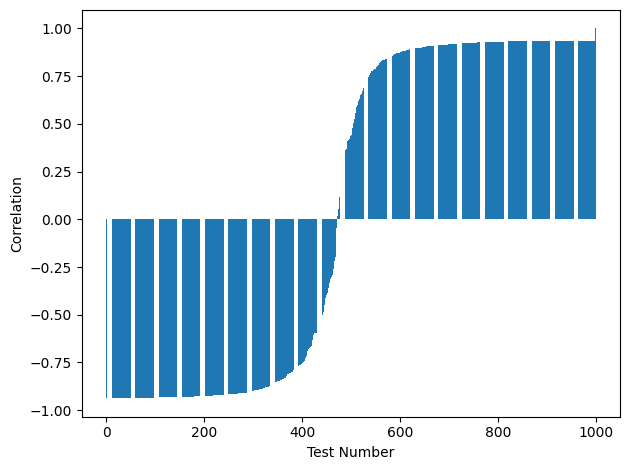

In [ ]:
plt.bar(range(NUM_TESTS), sorted(correlations))
# plt.xticks(range(NUM_TESTS), labels=[f'{i+1}' for i in range(NUM_TESTS)])  # Labeling x-axis with test numbers
plt.xlabel('Test Number')  # x-axis label
plt.ylabel('Correlation')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Max Difference: 0.04377457344106439
Min Difference: -0.03238974318037702
Mean Difference: -0.00577307942997558
Variance: 0.0003401528924745795
Standard Deviation: 0.018443234327920346


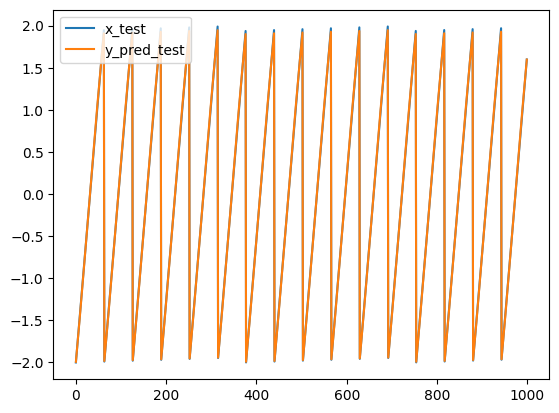

In [ ]:
# how about a sawtooth?
x_test = signal.sawtooth(np.arange(0, 100, 0.1))
y_gold_test = x_test*2

x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
y_pred_test = model(x_test_tensor).detach().cpu().numpy().squeeze()
fig, ax = plt.subplots()
# plt.plot(x_test)
plt.plot(y_gold_test)
plt.plot(y_pred_test)
plt.legend(['x_test', 'y_pred_test'])

differences = (y_gold_test) - y_pred_test
print(f'Max Difference: {np.max(differences)}')
print(f'Min Difference: {np.min(differences)}')
print(f'Mean Difference: {np.mean(differences)}')
print(f'Variance: {np.var(differences)}')
print(f'Standard Deviation: {np.std(differences)}')

plt.show()

In [ ]:
save = True

if save == True:
    torch.save(model.state_dict(), 'lstm_torch.pth')
    np.savetxt('lstm_torch_x_python.csv', x, delimiter=',')
    np.savetxt('lstm_torch_y_python.csv', y_pred_1d, delimiter=',')

    with open(f'lstm_torch_{hidden_size}.json', 'w') as json_file:
        json.dump(model.state_dict(), json_file,cls=EncodeTensor)
